# Desafio AInwater

Me dan una tabla con la información de una semana en una planta de tratamiento de aguas residuales. En la tabla se tienen  las siguientes variables:
- **date**: fecha de la lectura
- **time**: hora de la lectura
- **do_level** : nivel de oxígeno
- **h2o_level**: nivel de agua
- **blower_hz** : hz de giro del motor
- **cycle_id** : label para identificar los ciclos de funcionamiento

## Análisis del dataset

El dataset se encuentra en el fichero *base_test_planta_tupiniquim.csv*, y a continuación se realiza una vista del mismo con las primeras cinco observaciones


In [1]:
#########Librerias############

# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')


data=pd.read_csv('base_test_planta_tupiniquim.csv')
data.head()


,Unnamed: 0,date,time,do_level,h2o_level,blower_hz,cycle_id
0,6285,2021-04-14,00:00:28,1.693960,4.931112,0.0,0
1,6287,2021-04-14,00:02:35,1.401860,4.930655,0.0,0
2,6288,2021-04-14,00:05:35,1.134430,4.929771,0.0,0
3,6289,2021-04-14,00:08:35,0.929321,4.930228,0.0,0
4,6290,2021-04-14,00:11:35,0.882311,4.928187,0.0,0


El dataset contiene 7 variables con 3366 observaciones, y el tipo de datos de las variables se observa en la salida de los códigos siguientes.

In [2]:
data.shape

(3366, 7)

In [3]:
data.dtypes

Unnamed: 0      int64
date           object
time           object
do_level      float64
h2o_level     float64
blower_hz     float64
cycle_id        int64
dtype: object

Reviso si existen valores NaN.

In [4]:
data[data.isna().any(axis=1)]

,Unnamed: 0,date,time,do_level,h2o_level,blower_hz,cycle_id


Voy a convertir a datetime las variables date y time, el resto de las variables se mantiene con el tipo que le asigna pandas. 

In [5]:
data['date']=pd.to_datetime(data['date']).dt.date
data['time']=pd.to_datetime(data['time'])
data.dtypes

Unnamed: 0             int64
date                  object
time          datetime64[ns]
do_level             float64
h2o_level            float64
blower_hz            float64
cycle_id               int64
dtype: object

Reviso si puedo realizar alguna conclusión parcial de los datos observando los valores únicos por columnas.

In [6]:
data.nunique()


Unnamed: 0    3366
date             7
time          3366
do_level      3361
h2o_level     2172
blower_hz      133
cycle_id        36
dtype: int64

En principio se observa una variable sin nombre que parece almacenar un identificador para cada observación(fila). Existen 7 fechas, que se corresponden con la cantidad de días de la semana, y la variable *time* contiene la misma cantidad de filas como  valores únicos, por tanto no existen mediciones realizadas en el mismo instante de tiempo durante la semana. Además se tienen 36 ciclos de funcionamiento durante la semana. 

Voy a revisar las estadísticas descriptivas  de las variables numéricas importantes para ver como se comportan luego sus distribuciones.

In [7]:
feature_columns = data.select_dtypes('float').columns.tolist()
data[feature_columns].describe()

,do_level,h2o_level,blower_hz
count,3366.000000,3366.000000,3366.000000
mean,1.360852,4.586752,12.140579
std,1.582510,0.443547,19.798966
min,0.004908,3.910520,0.000000
25%,0.057467,4.253216,0.000000
50%,0.603368,4.397857,0.000000
75%,2.339908,5.018035,26.440001
max,5.716060,5.412021,50.240002


Se observa en la variable *blower_hz* que en el 50% de los datos la velocidad de rotacion del motor es de 0 hz, por lo que se puede decir que la mitad del tiempo el motor se encuentra apagado. Y solo en un 25% de los datos(percentil 75%) el motor alcanza una velocidad entre 26.44hz y la máxima 50.24hz. 

La variable *h2o_level* refleja que existe poca dispersion en los datos del nivel del agua y la mayoría se encuentra alrededor de la media que es 4.59. En el caso del nivel de oxigeno *do_level*, el 25% de los datos(que se encuentran en percentil 75%) poseen valores un poco alejados de la media. 

## Caracterizar el funcionamiento de la planta durante esta semana.
- hz totales por ciclo
- crear un label que identifique cual es en que posición del día se encuentra cada ciclo
- comparar el gasto energético entre los diferentes ciclos de cada día
- nivel medio de oxígeno por ciclo (y su distribución)
- nivel medio de oxígeno por ciclo para blower_hz > 0 (y su distribución)


**Hz totales por ciclo**

La gráfica refleja una variación de cinco ciclos en las velocidades de giro que alcanza el motor, estas comienzan cerca de los 1500hz y disminuyen paulatinamente entre el primer y tercer ciclo, luego hace una disminución brusca en el cuarto ciclo hasta alcanzar aproximadamente los 900hz. Y así se repite este patrón cada cinco ciclos de funcionamiento. 

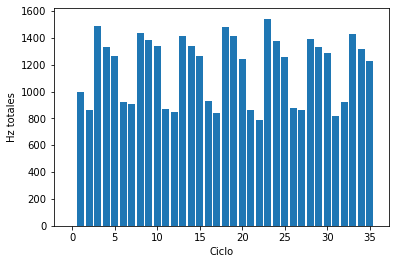

In [8]:
df=data.groupby(by=['cycle_id'])['blower_hz'].sum()

plt.bar(df.index, df)
plt.ylabel('Hz totales')
plt.xlabel('Ciclo')
plt.show()


**Crear un label que identifique en qué posición del día se encuentra cada ciclo**.

Para ello defino cuatro periodos del día: madrugada(de 24:00 a 4:59 horas), mañana (de 5:00 a 11:59 horas), tarde (de 12:00 a 18:59 horas) y noche las horas restantes. 

In [9]:
import datetime
def periodo_dia(row):
    intervalo_m_ini = datetime.time(5,0)
    intervalo_m_fin = datetime.time(11,59)
    intervalo_t_ini = datetime.time(12,0)
    intervalo_t_fin = datetime.time(18,59)
    intervalo_n_ini = datetime.time(19,0)
    intervalo_n_fin = datetime.time(23,59)
    if (intervalo_m_ini <= row['time'].time() <= intervalo_m_fin):
        return "mañana"
    elif (intervalo_t_ini <= row['time'].time() <= intervalo_t_fin):
        return "tarde"
    elif (intervalo_n_ini <= row['time'].time() <= intervalo_n_fin):
        return "noche"
    return "madrugada"

data['periodo_dia'] = data.apply(periodo_dia, axis=1)
data.head()

,Unnamed: 0,date,time,do_level,h2o_level,blower_hz,cycle_id,periodo_dia
0,6285,2021-04-14,2021-08-22 00:00:28,1.693960,4.931112,0.0,0,madrugada
1,6287,2021-04-14,2021-08-22 00:02:35,1.401860,4.930655,0.0,0,madrugada
2,6288,2021-04-14,2021-08-22 00:05:35,1.134430,4.929771,0.0,0,madrugada
3,6289,2021-04-14,2021-08-22 00:08:35,0.929321,4.930228,0.0,0,madrugada
4,6290,2021-04-14,2021-08-22 00:11:35,0.882311,4.928187,0.0,0,madrugada


**Comparar el gasto energético entre los diferentes ciclos de cada día**

Asumo que lo que me piden es comparar el gasto energético por período del dia, utilizando el label creado anteriormente. Es decir, el momento del día en que la planta consume mayor cantidad de energía. 

In [10]:
#agrupo por periodos del día en la semana
dfxperiodo=data.groupby(by=['periodo_dia'])['blower_hz'].sum()

#agrupo por dias y periodo del dia
dfxdias=data.groupby(by=['date','periodo_dia', ])['blower_hz'].sum()

nArray=dfxdias.xs('noche', level='periodo_dia', axis=0)
mArray=dfxdias.xs('mañana', level='periodo_dia', axis=0)
tArray=dfxdias.xs('tarde', level='periodo_dia', axis=0)
madArray=dfxdias.xs('madrugada', level='periodo_dia', axis=0)

X=madArray.index


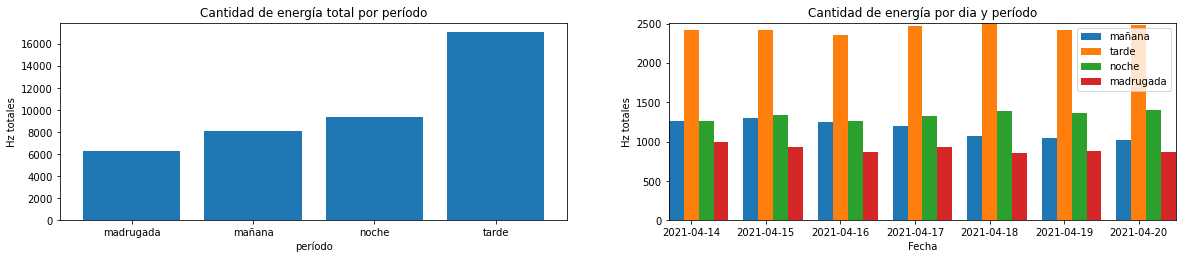

In [11]:
# plot 
plt.figure(figsize=(20,8))

plt.subplot(221)
plt.bar(dfxperiodo.index, dfxperiodo)
plt.ylabel('Hz totales')
plt.xlabel('período')
plt.title('Cantidad de energía total por período')


plt.subplot(222)
X_axis = np.arange(len(X))
width = 0.20  # the width of the bars

plt.bar(X_axis , mArray, width, label = 'mañana')
plt.bar(X_axis+width  , tArray, width, label = 'tarde')
plt.bar(X_axis+width*2, nArray, width, label = 'noche')
plt.bar(X_axis+width*3, madArray,width, label = 'madrugada')

plt.xticks(X_axis, X)
plt.xlabel("Fecha")
plt.ylabel("Hz totales")
plt.title("Cantidad de energía por dia y período")
plt.legend()
plt.xticks(X_axis + width, nArray.index)
plt.autoscale(tight=True)

plt.show()

Las gráficas reflejan que en el período de la tarde es cuando mayor cantidad de energía consume la planta, independientemente del día de la semana. Y cuando menos gasto energético ocurre es en la madrugada. La variación del consumo de energía en la mañana y en la noche es similar excepto los tres últimos días de la semana que se consume menos en la mañana que en la tarde. 

**Nivel medio de oxígeno por ciclo (y su distribución)**

En el histograma de frecuencias se observa una distribución no simétrica en los datos que reflejan el nivel de oxígeno. Estos datos están sesgados hacia la derecha, lo que significa que la mayor cantidad de mediciones contiene un nivel de oxígeno por debajo de la media y cercano a cero. En otras palabras, la mayoría del tiempo en que se realizan las mediciones el nivel de oxígeno es por debajo de la media 1.36. 


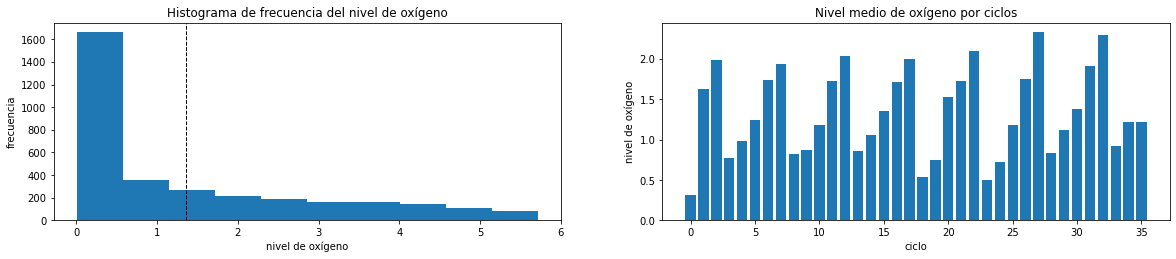

In [12]:
plt.figure(figsize=(20,8))

plt.subplot(221)
plt.hist(data['do_level'])
plt.axvline(data['do_level'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.xlabel("nivel de oxígeno")
plt.ylabel("frecuencia")
plt.title("Histograma de frecuencia del nivel de oxígeno")

plt.subplot(222)

df=data.groupby('cycle_id')['do_level'].mean()
plt.bar(df.index, df)

plt.xlabel("ciclo")
plt.ylabel("nivel de oxígeno")
plt.title("Nivel medio de oxígeno por ciclos")

plt.show()

En la gráfica del nivel medio de oxígeno por ciclos, se refleja cada cinco ciclos un aumento paulatino del nivel de oxígeno hasta alcanzar valores cercanos al nivel máximo 3.0, y luego cae bruscamente a valores por debajo de la media. 

**Nivel medio de oxígeno por ciclo para blower_hz > 0 (y su distribución)**

Las gráficas reflejan un comportamiento similar.

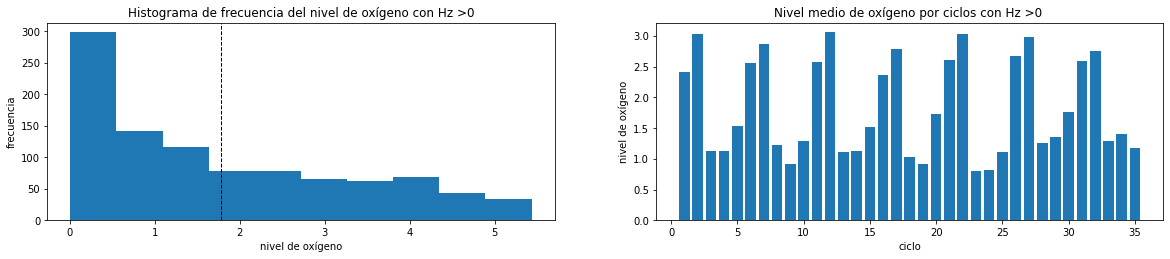

In [13]:
e=data[data['blower_hz'] > 0]

plt.figure(figsize=(20,8))

plt.subplot(221)
plt.hist(e['do_level'])
plt.axvline(e['do_level'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.xlabel("nivel de oxígeno")
plt.ylabel("frecuencia")
plt.title("Histograma de frecuencia del nivel de oxígeno con Hz >0")

plt.subplot(222)
df=data[data['blower_hz'] > 0].groupby('cycle_id')['do_level'].mean()
plt.bar(df.index, df)
plt.xlabel("ciclo")
plt.ylabel("nivel de oxígeno")
plt.title("Nivel medio de oxígeno por ciclos con Hz >0 ")
plt.show()          



# Bonus:
- caracterizar el nivel de agua por ciclo
- desarrollar un modelo de clusterización de los ciclos de esta semana



**Caracterizar el nivel de agua por ciclo**

En el histograma de frecuencias se observa una distribución no simétrica en los datos que reflejan el nivel de agua. La gráfica de cajas refleja que no existen valores atípicos, y una gran  parte del nivel de oxigeno es inferior a la media. 

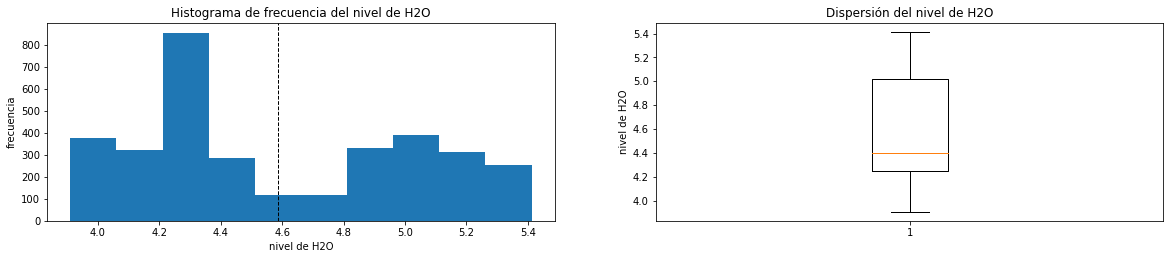

In [14]:
plt.figure(figsize=(20,8))

plt.subplot(221)
plt.hist(data['h2o_level'])
plt.axvline(data['h2o_level'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.xlabel("nivel de H2O")
plt.ylabel("frecuencia")
plt.title("Histograma de frecuencia del nivel de H2O")

plt.subplot(222)
plt.boxplot(data['h2o_level'])

plt.ylabel("nivel de H2O")
plt.title("Dispersión del nivel de H2O")
plt.show()

Si analizamos el nivel medio del agua por ciclos, el comportamiento es similar al nivel medio de oxígeno pero en sentido contrario, cada cinco ciclos desciende paulatinamente el nivel agua hasta valores alrededo de la media 4.6 y luego incrementa bruscamente a los niveles cerca del máximo 5.0. 

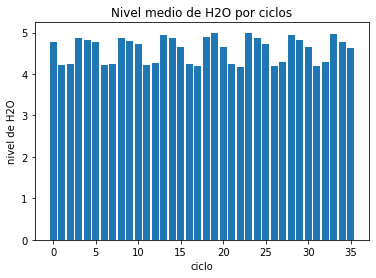

In [15]:
df=data.groupby('cycle_id')['h2o_level'].mean()
plt.bar(df.index, df)

plt.xlabel("ciclo")
plt.ylabel("nivel de H2O")
plt.title("Nivel medio de H2O por ciclos")
plt.show()

**Desarrollar un modelo de clusterización de los ciclos de esta semana**

Según el análisis descriptivo los ciclos se pueden agrupar en cinco grupos por el comportamiento medio de las variables *do_level* y *h2o_level*. Analizando el fenómeno más de cerca  se observa que los ciclos están dados por diferentes valores de  *blower_hz* incluido cuando el motor se encuentra apagado. Por tanto para el agrupamiento selecciono esas variables.

Primero compruebo cuán importantes son revisando su grado de correlación entre ellas y la variable *cycle_id*. 

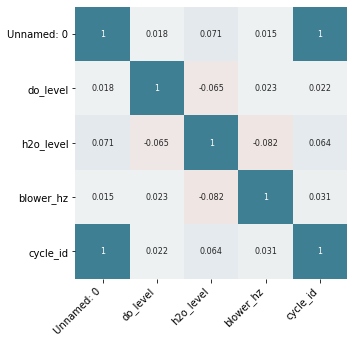

In [16]:
corr_matrix = data.corr(method='pearson')
corr_matrix

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

Tenemos que las tres variables no están correlacionadas por tanto son las que se pueden usar en el agrupamiento. Estas se escalan a una misma unidad de medida teniendo en cuenta que las distribuciones son asimétricas, por tanto es necesario normalizarlas.

In [17]:
# Selecciono las variables a usar
df=data[['do_level','h2o_level','blower_hz']]

# Escalado de las variables
# ==============================================================================
datos_scaled = scale(X=df, axis=0, with_mean=True, with_std=True) 
datos_scaled = pd.DataFrame(datos_scaled, columns=df.columns, index=df.index)
datos_scaled.head(4)


,do_level,h2o_level,blower_hz
0,0.210525,0.776495,-0.613284
1,0.025917,0.775464,-0.613284
2,-0.143099,0.773471,-0.613284
3,-0.272728,0.774502,-0.613284


Compruebo si se puede realizar el agrupamiento mediante el test de Hopkins, y el valor obtenido (0.06 < 0.5) refleja que sí es posible.

In [18]:
from pyclustertend import hopkins
hopkins(datos_scaled,3360)

0.061144990804409736

Aplico el método Elbow para identificar el número óptimo de clusters.

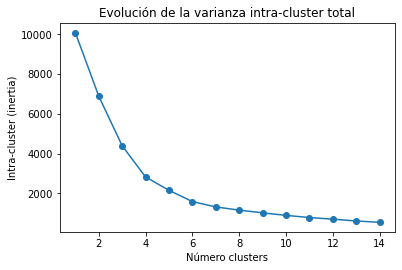

In [19]:
from sklearn.metrics import silhouette_score

# Método elbow para identificar el número óptimo de clusters
# ==============================================================================
range_n_clusters = range(1, 15)
inertias = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
                        n_clusters   = n_clusters, 
                        n_init       = 20, 
                        random_state = 123
                    )
    modelo_kmeans.fit(datos_scaled)
    inertias.append(modelo_kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)');

Selecciono el valor a partir del cual se observa el codo, aquel valor a partir del cual añadir más clusters apenas consigue mejoría, y eso está entre el valor 5 y 6. Escojo el 5 para discriminar mejor. 

In [20]:
kmeans = KMeans(n_clusters=5).fit(datos_scaled)
centroids = kmeans.cluster_centers_
print(centroids)

[[-0.35501625 -0.07410147  1.89002937]
 [ 1.47316834  1.1086304  -0.19440396]
 [-0.62479366 -0.73755664 -0.60968781]
 [-0.58540764  1.08471361 -0.61126863]
 [ 1.44969502 -0.80497811 -0.04116343]]


Realizo la predicción asignando a cada elemento del dataset su nueva etiqueta.

In [21]:
# Predicting the clusters
labels = kmeans.predict(datos_scaled)
# Getting the cluster centers
C = kmeans.cluster_centers_

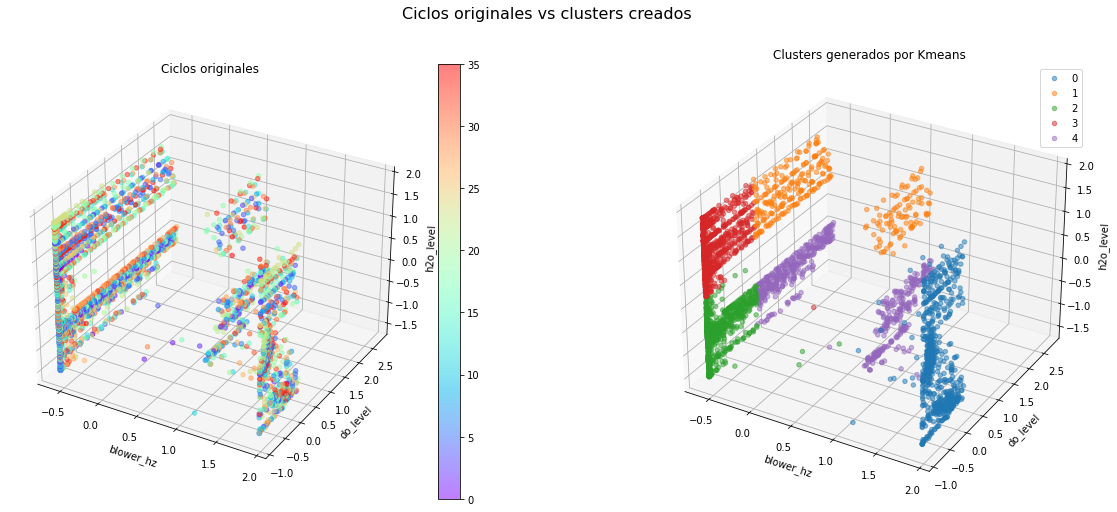

In [22]:
# Representación gráfica: ciclos originales vs clusters creados
# ==============================================================================
fig = plt.figure(figsize=(20,8))
fig.suptitle("Ciclos originales vs clusters creados", fontsize = 16)
#===============
#  First subplot
#===============

ax = fig.add_subplot(1, 2, 1, projection='3d')
sc = ax.scatter(datos_scaled['blower_hz'], datos_scaled['do_level'], datos_scaled['h2o_level'], 
                alpha=0.5,  cmap='rainbow', c=data['cycle_id'], s=20)
ax.set_title('Ciclos originales')
ax.set_xlabel('blower_hz')
ax.set_ylabel('do_level')
ax.set_zlabel('h2o_level')
plt.colorbar(sc)

#===============
# Second subplot
#===============

ax = fig.add_subplot(1, 2, 2, projection='3d')

xs = datos_scaled['blower_hz'].to_numpy()
ys = datos_scaled['do_level'].to_numpy()
zs = datos_scaled['h2o_level'].to_numpy()

for lbl in np.unique(labels):
    indices = np.where(labels == lbl)
    x = xs[indices]
    y = ys[indices]
    z = zs[indices]    
    ax.scatter(x, y, z, alpha=0.5, label=str(lbl), cmap='rainbow', s=20)

ax.set_title('Clusters generados por Kmeans')
ax.set_xlabel('blower_hz')
ax.set_ylabel('do_level')
ax.set_zlabel('h2o_level')

ax.legend()

plt.show()



En la gráfica de la izquierda, se observan los ciclos originales con las variables de importancia, y estos 35 ciclos no se diferencian. La gráfica de la derecha, que representa el agrupamiento realizado con Kmeans, refleja cinco grupos bien diferenciados. En esta gráfica existen algunos puntos alejados de su cluster, pero son pocos. 

Como vemos, los tamaños de los clusters son uniformes y todos los clusters tienen un comportamiento asociado en cuanto a los niveles de agua, oxígeno y la velocidad del motor. Con este resultado podríamos describir a nuestros clusters como:

- **cluster0 (azul)**:  Motor que alcanza velocidad máxima, con valores aislados pr encima de la media, con niveles de agua y oxígeno por debajo de la media. 
- **cluster1 (naranja)**: Motor apagado y en algunos casos con velocidad por debajo de la media, con niveles de oxígeno y agua por debajo de la media.
- **cluster2 (verde)**: Motor apagado o con velocidad que llega a alcanzar la media, con niveles de oxígeno y agua superiores a la media.
- **cluster3 (rojo)**:Motor apagado o con velocidad que llega a sobrepasar la media sin alcanzar niveles máximos, con niveles de oxígeno superiores a la media y niveles de agua inferiores a la media.
- **cluster4 (morado)**: Motor apagado y en un solo caso con velocidad por debajo de la media, con niveles de oxígeno por debajo de la media y niveles de agua superiores a la media.